In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import PIL
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import mediapipe as mp
from PIL import Image

In [2]:
base = "arch 7/train"
working_dir = os.path.join(base,'working')
train_working_dir = os.path.join(working_dir, 'train')
test_working_dir = os.path.join(working_dir, 'test')

In [3]:
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
os.makedirs(working_dir, exist_ok=True)
if os.path.exists(train_working_dir):
    shutil.rmtree(train_working_dir)
os.makedirs(train_working_dir, exist_ok=True)
if os.path.exists(test_working_dir):
    shutil.rmtree(test_working_dir)
os.makedirs(test_working_dir, exist_ok=True)
image_paths = []

In [4]:
annotation_dir = os.path.join((base), 'labels')
image_dir = os.path.join((base), 'images')
for filename in os.listdir(annotation_dir):
    if filename.endswith('.txt'):
        annotation_file = os.path.join(annotation_dir, filename)
        with open(annotation_file, 'r') as file:
            lines = file.readlines()
        lines = [line.split() for line in lines]
        df = pd.DataFrame(lines, columns=['class_name', 'xmin', 'ymin', 'xdistance', 'ydistance'])
        img_filename = filename.replace('.txt', '.jpg')  # replace with your image file extension
        img = cv2.imread(os.path.join(image_dir, img_filename))
        for index, row in df.iterrows():
            xmin = int((float(row['xmin']) - float(row['xdistance']) / 2) * img.shape[1])
            ymin = int((float(row['ymin']) - float(row['ydistance']) / 2) * img.shape[0])
            xmax = int((float(row['xmin']) + float(row['xdistance']) / 2) * img.shape[1])
            ymax = int((float(row['ymin']) + float(row['ydistance']) / 2) * img.shape[0])
            cropped_img = img[ymin:ymax, xmin:xmax]
        class_dir = os.path.join(working_dir, row['class_name'])
        os.makedirs(class_dir, exist_ok=True)
        class_dir = os.path.join(train_working_dir, row['class_name'])
        os.makedirs(class_dir, exist_ok=True)
        class_dir = os.path.join(test_working_dir, row['class_name'])
        os.makedirs(class_dir, exist_ok=True)
        reseized_img = cv2.resize(cropped_img, (256, 256))
        cropped_img_path = os.path.join(class_dir, img_filename)
        cv2.imwrite(cropped_img_path, reseized_img)
        image_paths.append(cropped_img_path)


In [5]:
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
for path in train_paths:
    # print(os.path.join(train_working_dir, os.path.basename(os.path.dirname(path)), os.path.basename(path)))
    os.rename(path, os.path.join(train_working_dir, os.path.basename(os.path.dirname(path)), os.path.basename(path)))
for path in test_paths:
    os.rename(path, os.path.join(test_working_dir, os.path.basename(os.path.dirname(path)), os.path.basename(path)))

In [6]:
# max_img_height = 0
# max_img_width = 0
# for i in os.listdir(train_working_dir):
#     for j in os.listdir(os.path.join(train_working_dir, i)):
#         img = cv2.imread(os.path.join(train_working_dir, i, j))
#         max_img_height = max(max_img_height, img.shape[0])
#         max_img_width = max(max_img_width, img.shape[1])
# for i in os.listdir(test_working_dir):
#     for j in os.listdir(os.path.join(test_working_dir, i)):
#         img = cv2.imread(os.path.join(test_working_dir, i, j))
#         max_img_height = max(max_img_height, img.shape[0])
#         max_img_width = max(max_img_width, img.shape[1])
# print(max_img_height, max_img_width)

In [7]:
train_generator = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1, height_shift_range=0.1, rotation_range=4, vertical_flip=False)
test_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_generator.flow_from_directory(train_working_dir, class_mode='categorical', batch_size=32, shuffle=True)
test_data_gen = test_generator.flow_from_directory(test_working_dir, class_mode='categorical', batch_size=32, shuffle=False)

Found 6574 images belonging to 8 classes.
Found 1644 images belonging to 8 classes.


In [8]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   134,218,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,408,776 (512.73 MB)

 Trainable params: 134,408,776 (512.73 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(8, activation='softmax'))
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

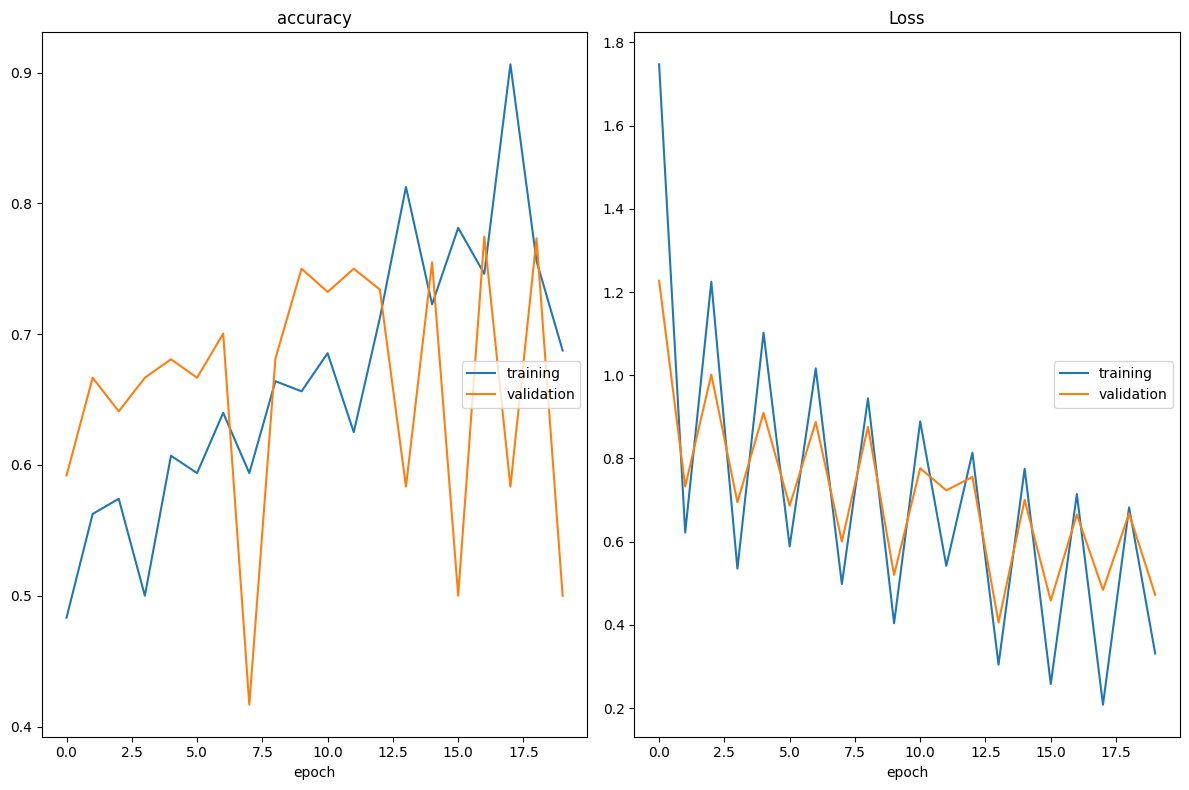

accuracy
	training         	 (min:    0.483, max:    0.906, cur:    0.688)
	validation       	 (min:    0.417, max:    0.775, cur:    0.500)
Loss
	training         	 (min:    0.208, max:    1.747, cur:    0.331)
	validation       	 (min:    0.406, max:    1.227, cur:    0.472)

Epoch 20: saving model to model_weights.weights.h5
205/205 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.6875 - loss: 0.3331 - val_accuracy: 0.5000 - val_loss: 0.4724 - learning_rate: 1.2500e-04


In [10]:
epochs = 20
steps_per_epoch = train_data_gen.n//32
validation_steps = test_data_gen.n//32
checkpoint = ModelCheckpoint('model_weights.weights.h5', monitor='val_accuracy',save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, mode='auto')
callbacks=[PlotLossesKeras(), checkpoint, reduce_lr]
history = model.fit(x=train_data_gen, steps_per_epoch = steps_per_epoch, epochs=epochs, validation_data=test_data_gen, validation_steps=validation_steps, callbacks=callbacks)

In [11]:
model.evaluate(test_data_gen)

52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - accuracy: 0.7669 - loss: 0.6471


[0.6759923100471497, 0.7688564658164978]

52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 460ms/step


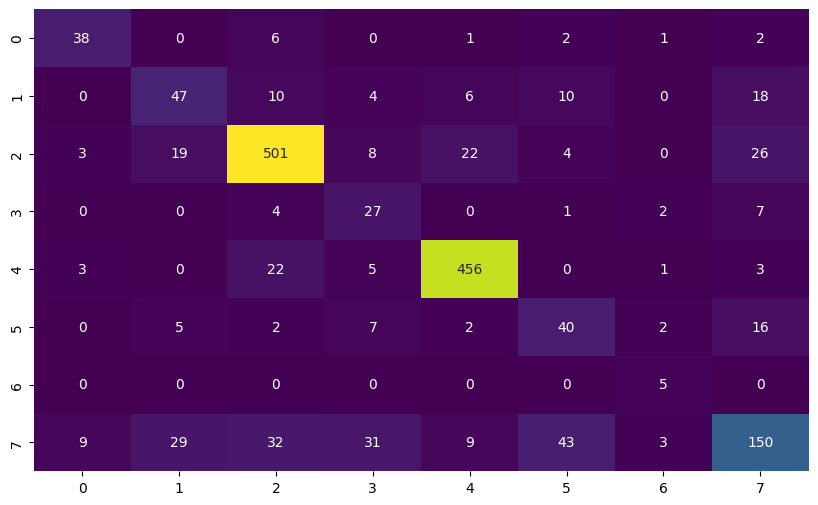

In [12]:
pred = model.predict(test_data_gen, test_data_gen.n//test_data_gen.batch_size)
sns.heatmap(confusion_matrix(np.argmax(pred,axis=1), test_data_gen.classes), annot=True, xticklabels=test_data_gen.class_indices.keys(), yticklabels=test_data_gen.class_indices.keys(), cbar=False, cmap='viridis',fmt='')
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

In [13]:
print(classification_report(np.argmax(pred,axis=1), test_data_gen.classes))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        50
           1       0.47      0.49      0.48        95
           2       0.87      0.86      0.86       583
           3       0.33      0.66      0.44        41
           4       0.92      0.93      0.92       490
           5       0.40      0.54      0.46        74
           6       0.36      1.00      0.53         5
           7       0.68      0.49      0.57       306

    accuracy                           0.77      1644
   macro avg       0.59      0.72      0.63      1644
weighted avg       0.78      0.77      0.77      1644



In [14]:
model_json = model.to_json()
with open('model_json.json', 'w') as json_file:
    json_file.write(model_json)

In [15]:
model.save("full_model.h5")